In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [68]:
from pandas import datetime

def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

series = pd.read_csv('datasets/shampoo_sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
series.head()

C:\Users\Dell\AppData\Local\Temp\ipykernel_392\2100456185.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime
C:\Users\Dell\AppData\Local\Temp\ipykernel_392\2100456185.py:6: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = pd.read_csv('datasets/shampoo_sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)


Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64

In [70]:

# Converting Series to DataFrame
df = pd.DataFrame(series)
df.head()

,Sales
Month,
1901-01-01,266.0
1901-02-01,145.9
1901-03-01,183.1
1901-04-01,119.3
1901-05-01,180.3


In [71]:
df.rename(columns = {'Sales':'sales'}, inplace = True)
df.head()

,sales
Month,
1901-01-01,266.0
1901-02-01,145.9
1901-03-01,183.1
1901-04-01,119.3
1901-05-01,180.3


In [72]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df.sales)
print("ADF statistics: ", result[0])
print("p-value: ", result[1])

ADF statistics:  3.0601420836411797
p-value:  1.0


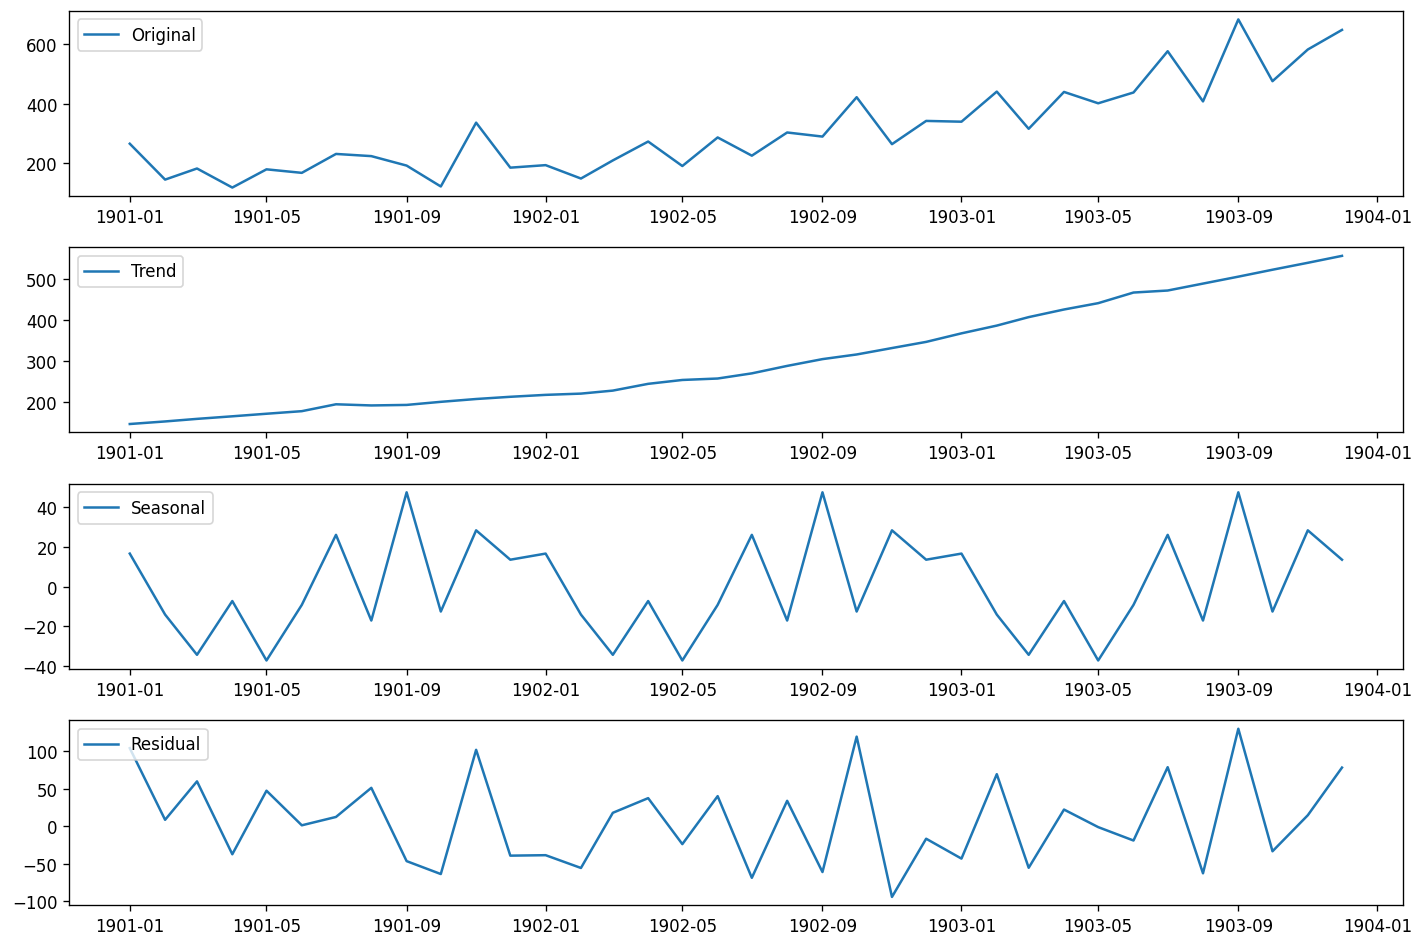

In [73]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Performing seasonal decomposition
decomposition = seasonal_decompose(df['sales'], model='additive', extrapolate_trend='freq')
# Plot the decomposed components
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(df['sales'], label='Original')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(decomposition.seasonal,label='Seasonal')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()



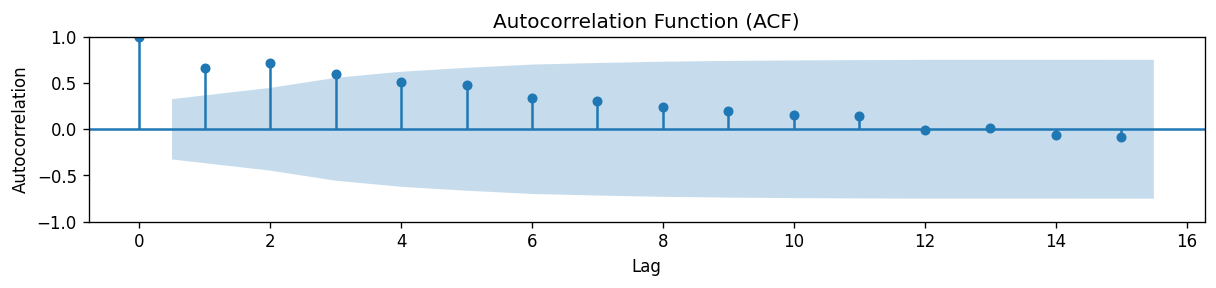

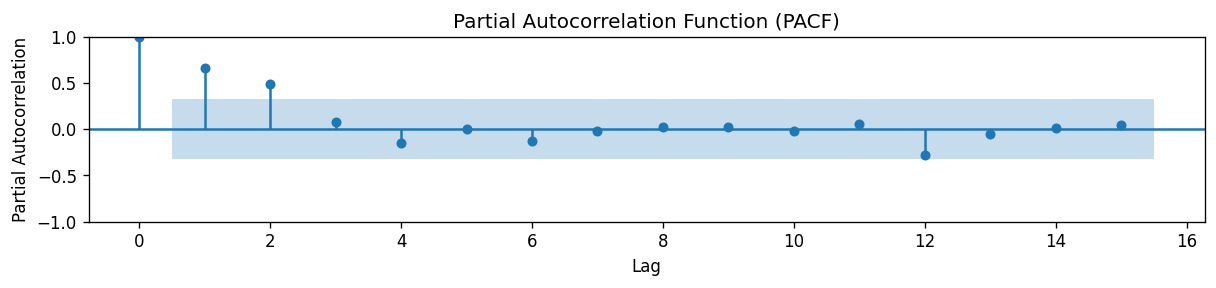

In [111]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

time_series = df['sales']
fig, ax = plt.subplots(figsize=(12, 2))
plot_acf(time_series, ax=ax, lags=15)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()
fig, ax = plt.subplots(figsize=(12, 2))
plot_pacf(time_series, ax=ax, lags=15)
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

In [75]:
result_1_diff = adfuller(df.sales.diff().dropna())
print("ADF statistics: ", result_1_diff[0])
print("p-value: ", result_1_diff[1])

ADF statistics:  -7.249074055553856
p-value:  1.7998574141687034e-10


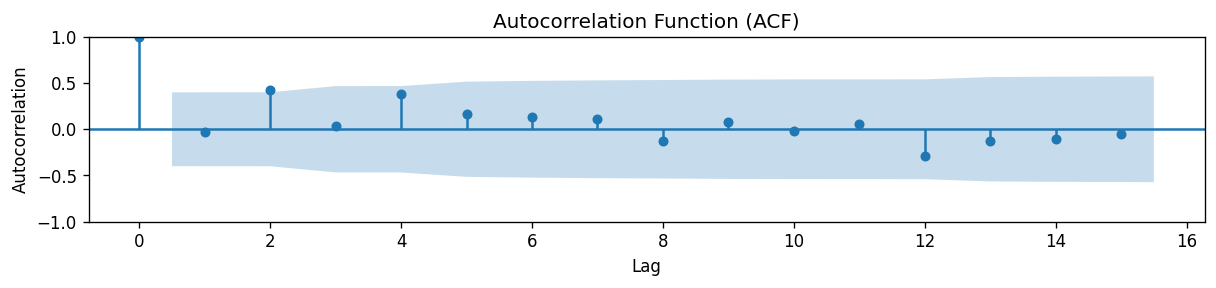

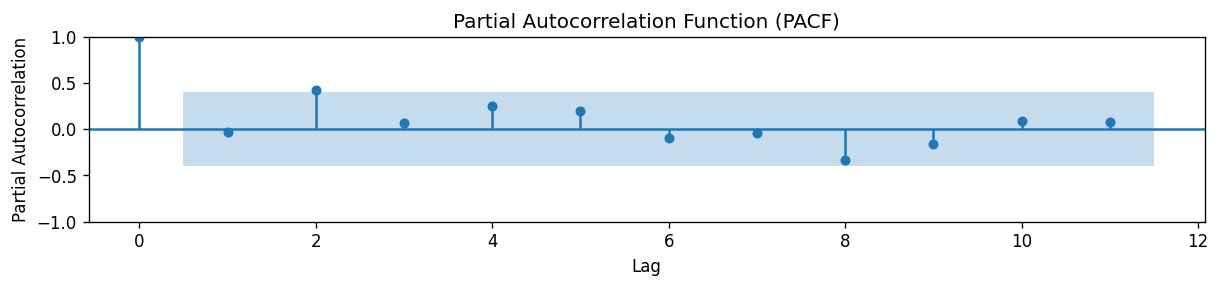

In [114]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

time_series = df['sales'].diff(12).dropna()
fig, ax = plt.subplots(figsize=(12, 2))
plot_acf(time_series, ax=ax, lags=15)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()
fig, ax = plt.subplots(figsize=(12, 2))
plot_pacf(time_series, ax=ax, lags=11)
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

In [115]:
result_2_diff = adfuller(df.sales.diff(12).diff().dropna())
print("ADF statistics: ", result_2_diff[0])
print("p-value: ", result_2_diff[1])

ADF statistics:  -6.356373983478786
p-value:  2.536894116868161e-08


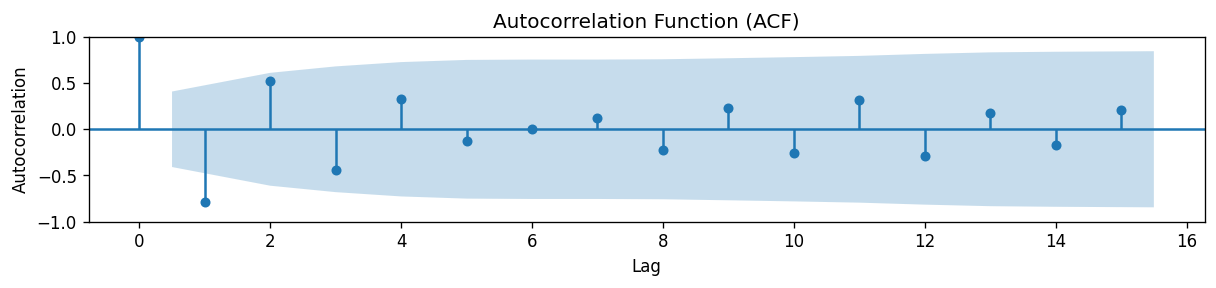

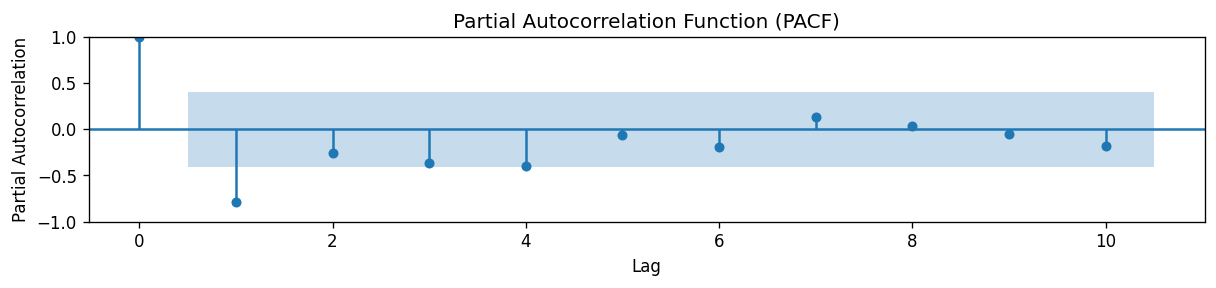

In [117]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

time_series = df['sales'].diff(12).diff().dropna()
fig, ax = plt.subplots(figsize=(12, 2))
plot_acf(time_series, ax=ax, lags=15)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()
fig, ax = plt.subplots(figsize=(12, 2))
plot_pacf(time_series, ax=ax, lags=10)
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

lets assume d = 1

<b>Find the order of the AR Term (p)</b>
using PACF

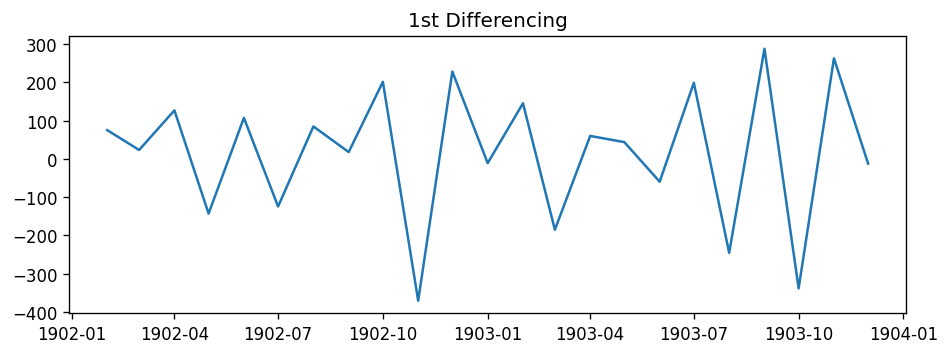

In [119]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 1, sharex=True)
axes.plot(df.sales.diff(12).diff()); axes.set_title('1st Differencing')
plt.show()

from pacf plot lets assume p-value (p=1)

<b>Find the order of the MA term (q)</b> using ACF

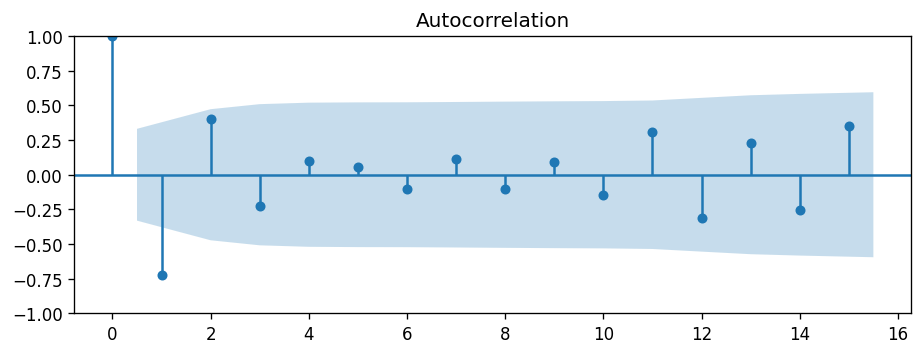

In [79]:
plot_acf(df.sales.diff().dropna(), lags=15)

plt.show()

let us assume Q value be (q=1)

<b>Build the ARIMA Model</b><br>
ARIMA(1, 1, 1) model

In [80]:
from statsmodels.tsa.arima.model import ARIMA

# 1,1,1 model
model = ARIMA(df.sales, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                   36
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -200.391
Date:                Tue, 08 Aug 2023   AIC                            406.782
Time:                        16:51:39   BIC                            411.448
Sample:                    01-01-1901   HQIC                           408.393
                         - 12-01-1903                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6003      0.201     -2.980      0.003      -0.995      -0.205
ma.L1         -0.2756      0.267     -1.033      0.302      -0.799       0.248
sigma2      5382.0426   1386.817      3.881      0.0

c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [81]:
# 1,2,1 model
model_121 = ARIMA(df.sales, order=(1,2,1))
model_fit_121 = model_121.fit()
print(model_fit_121.summary())

c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                   36
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -196.979
Date:                Tue, 08 Aug 2023   AIC                            399.959
Time:                        16:51:39   BIC                            404.538
Sample:                    01-01-1901   HQIC                           401.520
                         - 12-01-1903                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7328      0.126     -5.821      0.000      -0.980      -0.486
ma.L1         -0.9452      0.143     -6.592      0.000      -1.226      -0.664
sigma2      5630.4928   1644.522      3.424      0.0

The model AIC has reduced, which is good. The P Values of the AR1 and MA1 terms have improved and are highly significant (<< 0.05).

In [120]:
from pmdarima import auto_arima

best_model = auto_arima(df['sales'], seasonal=True, stepwise=True, information_criterion='aic', trace=True)
# Display the summary of the best model
print(best_model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=430.873, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=405.977, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=408.967, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=429.229, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=403.573, Time=0.12 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=404.633, Time=0.24 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=404.226, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=402.407, Time=0.35 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=401.463, Time=0.41 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec

Best 

In [121]:
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   36
Model:               SARIMAX(1, 1, 2)   Log Likelihood                -195.731
Date:                Tue, 08 Aug 2023   AIC                            401.463
Time:                        17:08:47   BIC                            409.240
Sample:                    01-01-1901   HQIC                           404.147
                         - 12-01-1903                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      9.3067      6.176      1.507      0.132      -2.798      21.412
ar.L1          0.0889      0.314      0.284      0.777      -0.526       0.704
ma.L1         -1.3866      0.314     -4.415      0.0

In [122]:
print(len(df))

36


In [164]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Splitting data into training and validation sets 
train = df.iloc[:28]
test = df.iloc[28:]

# Train the SARIMAX model with the best-fitted parameters
model = SARIMAX(train["sales"], order=(1,1,2), seasonal_order=(1,1,2,12))
results = model.fit()
print(results.summary())


c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parame

                                     SARIMAX Results                                      
Dep. Variable:                              sales   No. Observations:                   28
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 12)   Log Likelihood                 -87.875
Date:                            Tue, 08 Aug 2023   AIC                            189.750
Time:                                    17:25:47   BIC                            194.707
Sample:                                01-01-1901   HQIC                           189.698
                                     - 04-01-1903                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0000      0.015    -64.923      0.000      -1.030      -0.970
ma.L1          0.2118      8.427   

In [167]:

forecast_periods = 8


forecast = results.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()


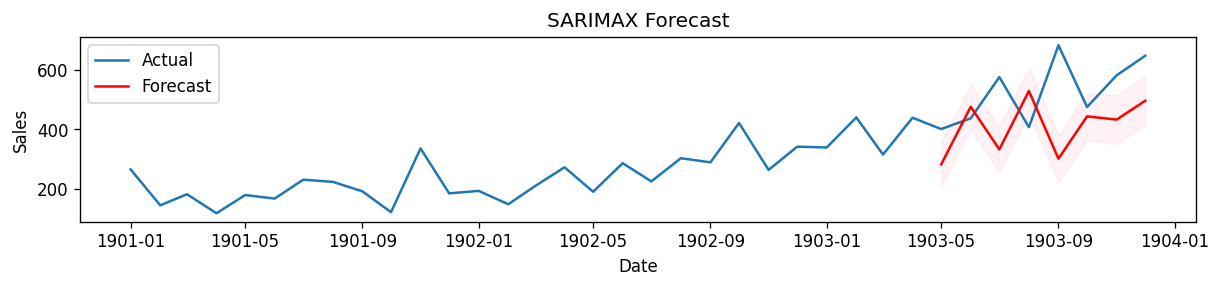

In [169]:
# Plotting actual data and forecasts
plt.figure(figsize=(12, 2))
plt.plot(df['sales'], label='Actual')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_conf_int.index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('SARIMAX Forecast')
plt.legend()
plt.show()


It may be possible that the dataset is not sufficiently large, hence the predicted values are not too accurate.

<b>Plot the residuals to ensure there are no patterns, (that is, look for constant mean and variance).

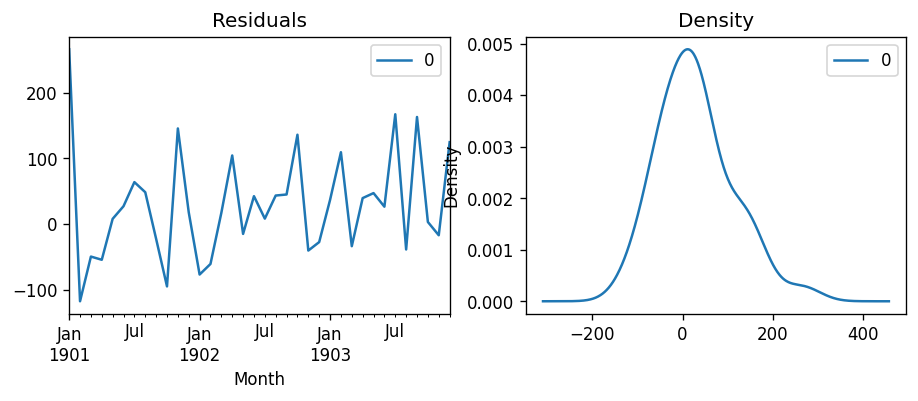

In [170]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

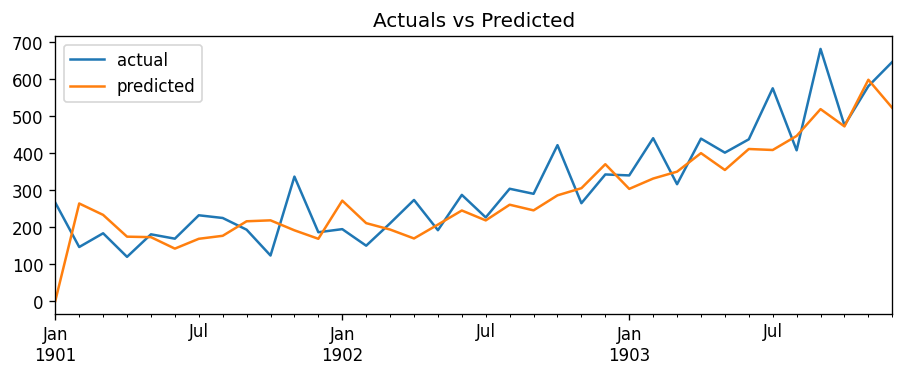

In [171]:
# Actual vs Fitted Plot
actual = df.sales
predicted = model_fit.predict()
pd.DataFrame({'actual':actual, 'predicted':predicted}).plot(title='Actuals vs Predicted');